A phoneme is defined by Google as "any of the perceptually distinct units of sound in a specified language that distinguish one word from another; for example, p, b, d, and t in the English words pad, pat, bad, and bat."

# Derivatives and such

We want to find a sequence of time stamps which divide the audio into phonemes. We'd like to test the hypothesis that phoneme boundaries occur where the change in certain features is most acute; that is, where the derivative along some dimension of the feature space has the greatest magnitude.

We don't have the expertise to mark phoneme boundaries by hand, and we feel that even expert human judgment is prone to produce errors. Thus we judge the output of various attempts simply by checking whether the division is reasonable to the human ear.

In [ ]:
from matplotlib import pyplot as plt
from scipy.io import wavfile
import numpy as np
from scripts.prepare import split_audio as audio
import IPython.display as ipd
plt.rcParams['figure.figsize'] = [8, 5]
from scripts.recognize.recognize import PhonemeSimilarity

In [2]:
%matplotlib notebook

In [3]:
s = audio.SoundWave(*wavfile.read('sample/00001_clean.wav'))
ipd.Audio('sample/00001_clean.wav')

In [4]:
def find_key(dictionary, value):
    """Finds the first key corresponding to `value` in the dictionary."""
    for k, v in dictionary.items():
        if v == value:
            return k


def find_n_fastest(sound, n, feature='cepstrum'):
    """Find the n positions where the given feature changes the fastest."""
    
    if feature == 'cepstrum':
        feature = sound.cepstrum()
    elif feature == 'spectrogram':
        feature = sound.spectrogram()
    elif feature == 'dft':
        feature = sound.dft()
    
    prev = None
    fastest = {}
    
    for idx, val in enumerate(feature):
        if 0 < idx <= n:
            # the first n samples are loaded into the `fastest` dictionary
            fastest[idx] = np.linalg.norm(val - prev)
        elif prev is not None:
            # every sample after n is compared with those in the dictionary
            diff = np.linalg.norm(val - prev)
            current_min = min(fastest.values())
            if diff > current_min:
                # replace the worst best entry with the new one
                del fastest[find_key(fastest, current_min)]
                fastest[idx] = diff

        prev = val
    
    return fastest

<IPython.core.display.Javascript object>


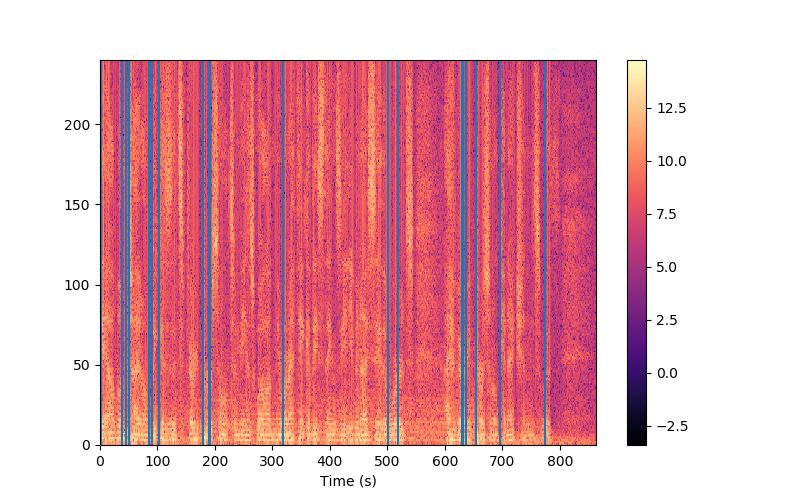

DFT	Spec	Ceps
0.04	0.39	0.39
0.05	0.46	0.46
0.06	0.51	0.51
0.08	0.85	0.85
0.09	0.91	0.91
0.58	1.03	1.03
0.59	1.80	1.80
0.95	1.89	1.89
1.60	1.91	1.91
1.61	3.19	3.19
1.62	4.46	4.46
1.82	5.01	5.01
1.83	5.15	5.15
1.84	5.19	5.19
1.85	6.29	6.29
3.49	6.32	6.32
4.86	6.37	6.37
6.29	6.55	6.55
6.37	6.96	6.96
6.38	7.75	7.75


In [5]:
quantity = 20
spec = list(find_n_fastest(s, quantity, 'spectrogram').keys())

# plot the spectrogram
s.plot(mode='spectrogram')

# add vertical lines where the spectrum changed the most from one window to the next
for point in spec:
    plt.axvline(x=point)
plt.show()

# do the same with DFT and cepstrum, and compare
dft = list(find_n_fastest(s, quantity, 'dft').keys())
cep = list(find_n_fastest(s, quantity, 'cepstrum').keys())

print('DFT\tSpec\tCeps')
for i in range(quantity):
    print('{:.2f}\t{:.2f}\t{:.2f}'.format(dft[i] * 0.01, cep[i] * 0.01, cep[i] * 0.01))

## Embedding spaces

For a set $\Omega$ of objects (e.g. audio, images, or text), an **embedding space** $(V,F)$ is defined by a metric space $V$ and an invertible function $F:\Omega\rightarrow V$ that maps objects from $\Omega$ to the vector space $V$. The goal is to "embed" these objects in an $n$-dimensional space where metric distance and vector addition become meaningful in some way.

With phonemes, the ideal would for distance to correlate with phonetic differences between two phonemes. In addition, meaningful vector addition would imply the following illustrative example:

$\qquad F(\text{/v/}) - F(\text{/f/}) + F(\text{/p/}) \approx F(\text{/b/})$.

(The difference between /v/ and /f/ is voicing, and when voicing is added to /p/ the result is /b/.)

Finding such a function $F$ is extremely valuable in creating a loss function for unsupervised phonetic transcription, as will be explained later on.

### The optimization problem

The following is a summary explanation of the concepts found in [3].

If each object can be represented as a vector $\mathbf x\in\mathbb R^n$, we can formulate finding the embedding function as an optimization problem over the space $M_n$ of matrices of size $n\times n$. If $x,y\in\mathbb R^n$ and $A\in M_n$ such that $A\succeq 0$, define the following distance metric:

$d_A(x,y)=||x-y||_A=\sqrt{(x-y)^\top A(x-y)}$.

In addition, let $S$ be a set of pairs such that for each pair $(x_i,x_j)\in S$ it is known that $x_i$ is similar to $x_j$. Similarly, let $D$ be a set of pairs such that for each pair $(x_i,x_j)\in D$ it is known that $x_i$ is dissimilar to $x_j$. Then the optimal embedding function is $A^{1/2}$, where $A$ is the solution to the following optimization problem:

$\qquad\min_A\sum_{(x_i,x_j)\in S}||x_i-x_j||_A^2$,

$\qquad\text{subject to }\sum_{(x_i,x_j)\in D}||x_i-x_j||_A\geq 1$,

$\qquad\qquad\qquad A\succeq 0$.

We can use gradient descent (or stochastic gradient descent if $S$ and $D$ are large) to optimize $A$. The algorithm is described in detail in [3].

[3] Xing, et al. "Distance metric learning, with application to clustering with side-information", UC Berkeley, 2003.

In [ ]:
# need to add some explanation of the algorithm here

Here is some example code that will predict the phoneme found in the sample:

In [ ]:
# if `phonemes` is a dictionary mapping phoneme characters to lists of SoundWave objects,
# the following will work. (work in progress)
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Voiced_bilabial_plosive.wav")
sample = audio.SoundWave(rate, wave[3079:4491])
recognizer = PhonemeSimilarity(phonemes)
print(recognizer.predict(sample))  # should print 'b'